# 1. 基础配置及公共函数

In [190]:
import pandas as pd

spring_festival = pd.DataFrame({
    'holiday': 'spring_festival',
    'ds': [
        # 2018年春节
        '2018-02-15', #'2018-02-16', '2018-02-17', '2018-02-18', '2018-02-19', '2018-02-20', '2018-02-21', 
        # 2019年春节
        '2019-02-04', #'2019-02-05', '2019-02-06', '2019-02-07', '2019-02-08', '2019-02-09', '2019-02-10', 
        ],
    'lower_window': 0,
    'upper_window': 7,
})
spring_festival_2019 = pd.DataFrame({
    'holiday': 'spring_festival_2019',
    'ds': [
        # 2018年春节
        #'2018-02-15', '2018-02-16', '2018-02-17', '2018-02-18', '2018-02-19', '2018-02-20', '2018-02-21', 
        # 2019年春节
        '2019-02-04', #'2019-02-05', '2019-02-06', '2019-02-07', '2019-02-08', '2019-02-09', '2019-02-10', 
        ],
    'lower_window': 0,
    'upper_window': 7,
})

# 国庆节
national_day = pd.DataFrame({
    'holiday': 'national_day',
    'ds': [
        '2017-10-01',
        '2018-10-01',
        ],
    'lower_window': 0,
    'upper_window': 7,
})
# holidays = pd.concat([spring_festival, spring_festival_2019])
holidays = pd.concat([spring_festival, national_day])

In [183]:
%matplotlib inline
from fbprophet import Prophet

def ds_predict(df_date, periods=30, **kwargs):
    m = Prophet(holidays=holidays, daily_seasonality=False, **kwargs)
    m.fit(df_date)
    future = m.make_future_dataframe(periods=periods)
    forecast = m.predict(future)
    m.plot(forecast)
    m.plot_components(forecast)
    
def df_by_id(df, id_str):
    df_id = df[df['变压器编号'] == id_str]
    print(df_id.count())
    df_id = df_id.groupby('日期').apply(lambda t: t[t['最大负载率']==t['最大负载率'].max()])
    print('去重过滤之后: ', df_id.count())
    return pd.DataFrame({'ds': df_id['日期'], 'y': df_id['最大负载率']})

# 2. 数据清洗及探索

In [33]:
%%time
import pandas as pd
from time import time

excel_filenames = ['公变201705-201708.xlsx', '公变201709-201711.xlsx', '公变201712-201802.xlsx', 
                   '公变201803-05.xlsx', '公变20186-8月.xlsx', '公变20189-11月.xlsx', 
                   '公变201812-20191月.xlsx', '公变20192-3月.xlsx', '公变20194-5月.xlsx']
fieldnames = ['日期', '最大负载率', '变压器编号', '变压器名', '区局', '供电所']

# 加载数据
all_data = None
for ef in excel_filenames:
    print(ef)
    start = time()
    df = pd.read_excel(ef, usecols=fieldnames)
    df.info()
    print('耗时：', time()-start)
    if all_data is None:
        all_data = df
    else:
        all_data = all_data.append(df, ignore_index=True)
        
# 写入文件
all_data.to_csv('date.csv', compression='gzip')
all_data.info()
all_data = None

公变201705-201708.xlsx
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846696 entries, 0 to 846695
Data columns (total 6 columns):
日期       846696 non-null object
最大负载率    846696 non-null float64
区局       846696 non-null object
供电所      846696 non-null object
变压器编号    846696 non-null object
变压器名     846696 non-null object
dtypes: float64(1), object(5)
memory usage: 38.8+ MB
耗时： 211.42950677871704
公变201709-201711.xlsx
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 647256 entries, 0 to 647255
Data columns (total 6 columns):
日期       647256 non-null object
最大负载率    647256 non-null float64
区局       647256 non-null object
供电所      647256 non-null object
变压器编号    647256 non-null object
变压器名     647256 non-null object
dtypes: float64(1), object(5)
memory usage: 29.6+ MB
耗时： 162.54744458198547
公变201712-201802.xlsx
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 662819 entries, 0 to 662818
Data columns (total 6 columns):
日期       662819 non-null object
最大负载率    662819 non-null float64
区局  

In [178]:
df = pd.read_csv('date.csv', compression='gzip')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6189365 entries, 0 to 6189364
Data columns (total 7 columns):
Unnamed: 0    int64
日期            object
最大负载率         float64
区局            object
供电所           object
变压器编号         object
变压器名          object
dtypes: float64(1), int64(1), object(5)
memory usage: 330.5+ MB


In [187]:
df.tail()

,Unnamed: 0,日期,最大负载率,区局,供电所,变压器编号,变压器名
6189360,6189360,2019-05-14,6.15,龙川供电局,佗城供电所,16227036,佗城坪田村下村公变
6189361,6189361,2019-05-14,3.67,东源供电局,船塘供电所,160900008161,船塘镇李田村石罗#1公变
6189362,6189362,2019-05-14,10.25,紫金供电局,古竹供电所,1111111115025909,赖坑公变
6189363,6189363,2019-05-14,30.62,连平供电局,隆街供电所,160900003629,连平县隆街所沐河村3#台区
6189364,6189364,2019-05-14,42.21,紫金供电局,柏埔供电所,1111111112031654,福田山下公变


In [139]:
# 查看负载比较高的数据
df_more = df[df['最大负载率'] > 75]
id_list = df_more['变压器编号'].value_counts()
print(type(id_list))
print(id_list[:10])
print(id_list[-10:])

<class 'pandas.core.series.Series'>
16DB05DG514         517
16LK040040          456
160900009516        407
160900004291        350
16LK04G001          327
16ZJ06T075          322
160900000558        320
1111111112155555    294
16LK05LG40          283
160900007822        262
Name: 变压器编号, dtype: int64
16ZJ01T132        1
16220078          1
16PQ01PG03        1
16PT09PG02        1
16ZD0900014484    1
16ZJ07T046        1
16ZX06GG07        1
16ZJ05T054        1
16ZJ22T012        1
16ZJ09T047        1
Name: 变压器编号, dtype: int64


# 3. 建模分析

      Unnamed: 0          日期  最大负载率     区局    供电所             变压器编号  \
2563        2563  2017-08-01   2.57  紫金供电局  紫城供电所  1111111111655086   

               变压器名  
2563  合威中央花园配电房#1公变  
Unnamed: 0    1472
日期            1472
最大负载率         1472
区局            1472
供电所           1472
变压器编号         1472
变压器名          1472
dtype: int64
去重过滤之后:  Unnamed: 0    736
日期            736
最大负载率         736
区局            736
供电所           736
变压器编号         736
变压器名          736
dtype: int64


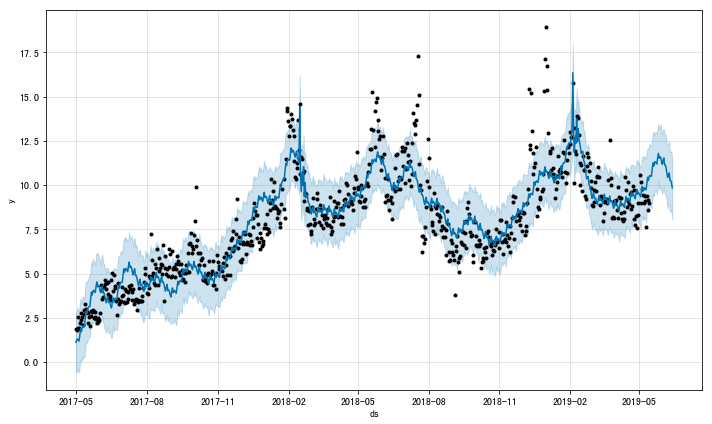

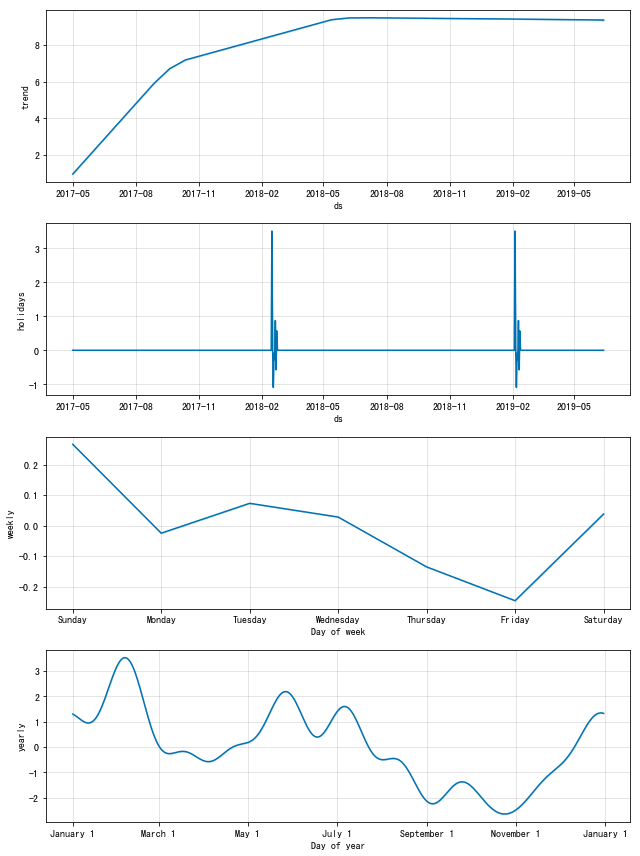

In [184]:
# 16DB05DG514 16LK040040  160900009516 
# 16ZD0900009825 16NG05NG07 
# 1111111111655086
# 有效ID：16DB05DG514  1111111111655086

id_str = '1111111111655086'
print(df[df['变压器编号'] == id_str].head(1))
df_date = df_by_id(df, id_str)
ds_predict(df_date)

      Unnamed: 0          日期  最大负载率     区局    供电所        变压器编号   变压器名
1961        1961  2017-08-01  99.02  和平供电局  大坝供电所  16DB05DG514  黄草嶂公变
Unnamed: 0    724
日期            724
最大负载率         724
区局            724
供电所           724
变压器编号         724
变压器名          724
dtype: int64
去重过滤之后:  Unnamed: 0    724
日期            724
最大负载率         724
区局            724
供电所           724
变压器编号         724
变压器名          724
dtype: int64


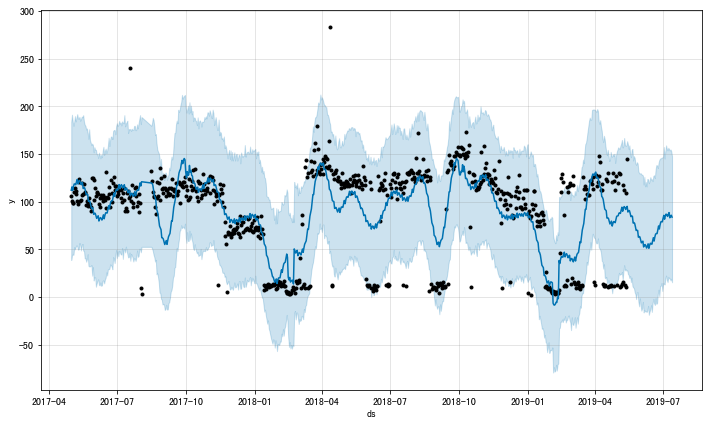

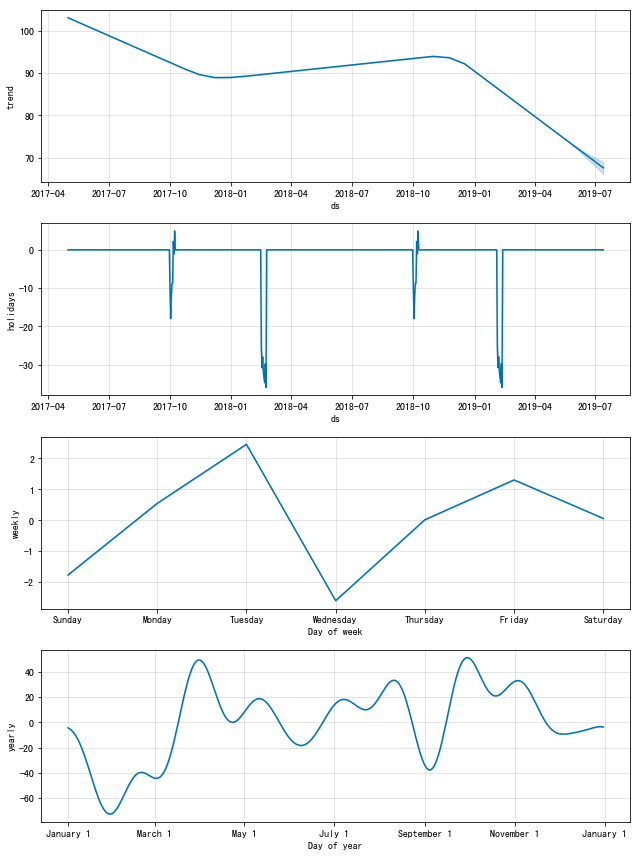

In [192]:
# 预测区间的宽度（默认下，是 80% ）可以通过设置 interval_width 参数来控制
# 有效ID：16DB05DG514  1111111111655086
id_str = '16DB05DG514'
print(df[df['变压器编号'] == id_str].head(1))
df_date = df_by_id(df, id_str)
ds_predict(df_date, periods=60, interval_width=0.95)

In [158]:
m.plot_components?
Prophet?

In [188]:
df[(df['日期'] > '2019-02-01') & (df['日期'] < '2019-02-25') & (df['变压器编号'] == id_str)]

,Unnamed: 0,日期,最大负载率,区局,供电所,变压器编号,变压器名
5452051,5452051,2019-02-02,7.15,紫金供电局,紫城供电所,1111111111655086,合威中央花园配电房#1公变
5455736,5455736,2019-02-02,12.74,紫金供电局,紫城供电所,1111111111655086,合威中央花园配电房#1公变
5461045,5461045,2019-02-03,7.17,紫金供电局,紫城供电所,1111111111655086,合威中央花园配电房#1公变
5463988,5463988,2019-02-03,12.73,紫金供电局,紫城供电所,1111111111655086,合威中央花园配电房#1公变
5470535,5470535,2019-02-04,6.55,紫金供电局,紫城供电所,1111111111655086,合威中央花园配电房#1公变
5477712,5477712,2019-02-04,15.74,紫金供电局,紫城供电所,1111111111655086,合威中央花园配电房#1公变
5486252,5486252,2019-02-05,6.50,紫金供电局,紫城供电所,1111111111655086,合威中央花园配电房#1公变
5486616,5486616,2019-02-05,13.21,紫金供电局,紫城供电所,1111111111655086,合威中央花园配电房#1公变
5492413,5492413,2019-02-06,10.12,紫金供电局,紫城供电所,1111111111655086,合威中央花园配电房#1公变
5492770,5492770,2019-02-06,6.35,紫金供电局,紫城供电所,1111111111655086,合威中央花园配电房#1公变
